# Simulating Some Micrographs

This notebook demonstrates how to use TEM-simulator to create synthetic cryoEM images that we can later use to demonstrate the entire reconstruction pipeline. It also provides a mean for us to determine differences between simulated and real data; and also the efficiency of the reconstruction process.

First we import some modules

In [23]:
%matplotlib inline
import os
import sys

# package up sometime?
sys.path.append('../src/')
import simutils
import cryoemio

# and of course our favourite modules
import numpy as np
from matplotlib import pyplot as plt

We cheat here, we don't really want to write a simulator in a python notebook, and instead we reference the binary of the simulator we shall use

In [2]:
SIMULATOR_BIN='/gpfs/slac/cryo/fs1/g/ML/cryoEM-notebooks/data/Simulation/TEM-simulator'

# Simulation setup

## Setting parameters

### molecular model

Here we define the actual molecule that we want to simulate imaging. We specify the directory where we keep all the pdb files and the name of the pdb structure.

In [3]:
PDB_DIR    = 'material/simple_data/' # relative path to directory containing candidate PDB fiels
PDB        = '4v6x'                  # ID of PDB file found in pdbdir

In [4]:
voxel_size      = 0.1                # [nm]
particle_name   = 'toto'             # Name of the particle. Not very important.
particle_mrcout = None               # volume map of sample is written.

### specimen grid parameters

In [5]:
hole_diameter         = 1200 # [nm]
hole_thickness_center = 100  # [nm]
hole_thickness_edge   = 100  # [nm]

### beam parameters

In [6]:
voltage           = 300 # [kV]
energy_spread     = 1.3 # [V]
electron_dose     = 100 # [e/nm**2] dose per image
electron_dose_std = 0   # standard deviation of dose per image

### optics parameters

In [7]:
magnification         = 81000 #
spherical_aberration  = 2.7   # [mm]
chromatic_aberration  = 2.7   # [mm]
aperture_diameter     = 50    # [um] in back focal plane
focal_length          = 3.5   # [mm]
aperture_angle        = 0.1   # [mrad] of the condenser lens
defocus               = 1.0   # [um]
defocus_syst_error    = 0.0   #
defocus_nonsyst_error = 0.0   #
optics_defocusout     = None  # file to write defocus values

### detector parameters

In [8]:
detector_Nx           = 5760 # number of pixels along X axis
detector_Ny           = 4092 # number of pixels along Y axis
detector_pixel_size   = 5    # [um]
detector_gain         = 32   # average number of counts per electron
detector_Q_efficiency = 0.5  # detector quantum efficiency
noise                 = 'no' # whether quantized electron waves result in noise
MTF_params            = [0,0,1,0,0] # to be described. [0,0,1,0,0] is perfect detector.

### output

We put all the outputs into this directory

In [9]:
OUTPUT_DIR = '/gpfs/slac/cryo/fs1/g/ML/cryoEM-notebooks/data/Simulation/synthetic_datasets/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Simulate data

## Prepare input file

### 1. Define the filenames and assemble some input arrays

In [10]:
SPECIMEN_KEYWORD   = PDB #+'_copy1'
MICROGRAPH_KEYWORD = PDB+'_randomrot'

In [11]:
pdb_file, mrc_file, crd_file, log_file, inp_file, h5_file = cryoemio.simio(PDB_DIR, PDB, SPECIMEN_KEYWORD, OUTPUT_DIR, MICROGRAPH_KEYWORD)
if particle_mrcout is not None:
    particle_mrcout = mrc_file

In [30]:
sample_dimensions = [ hole_diameter, hole_thickness_center, hole_thickness_edge ]
beam_params       = [ voltage, energy_spread, electron_dose, electron_dose_std ]
optics_params     = [ magnification, spherical_aberration, chromatic_aberration, 
                      aperture_diameter, focal_length, aperture_angle,
                      defocus, defocus_syst_error, defocus_nonsyst_error, optics_defocusout ]
detector_params   = [ detector_Nx, detector_Ny, detector_pixel_size, 
                      detector_gain, noise, detector_Q_efficiency,
                      MTF_params[0], MTF_params[1], MTF_params[2], MTF_params[3], MTF_params[4] ]

In [31]:
xy_range, numpart = simutils.define_grid(sample_dimensions,
                                         pdb_file=pdb_file,
                                         Dmax=30)

Maximum dimension of the molecule: 30 nm
Grid of 356 molecules that cover the volume: -424 nm --> 424 nm (step size: 45 nm)


### 2. Build specimen coordinate file (grid of particles)

In [13]:
simutils.write_crd_file(numpart, xrange = xy_range, yrange = xy_range, crd_file = crd_file)

### 3. Build input dictionary

In [14]:
#help(simutils.fill_parameters_dictionary)

In [15]:
params_dictionary = simutils.fill_parameters_dictionary(mrc_file = mrc_file, 
                                                        pdb_file = pdb_file, 
                                                        particle_mrcout = particle_mrcout, 
                                                        crd_file = crd_file,
                                                        sample_dimensions = sample_dimensions,
                                                        beam_params = beam_params,
                                                        optics_params = optics_params,
                                                        detector_params = detector_params,
                                                        log_file = log_file,
                                                        seed=1234)

### 4. Format dictionary in input file

In [16]:
simutils.write_inp_file(inp_file = inp_file, dict_params = params_dictionary)

## Run the simulation

In [17]:
os.system('{0} {1}'.format(SIMULATOR_BIN, inp_file))

0

# Package the output
We want to store the simulated micrograph together with all the input parameters in a unique file. Maybe hdf5 ?

In [22]:
cryoemio.mrc2hdf5(mrc_file = mrc_file, h5_file = h5_file, dic = params_dictionary)

# let's see what we just did
dd = cryoemio.load_dict_from_hdf5(h5_file)
for element in dd:
    print(element)
    if(element=='data'):
        print('... micrograph dimensions: {0}'.format(dd[element].shape))

beam
data
... micrograph dimensions: (4092, 5760)
detector
optics
particle
particleset
sample
simulation


# Display synthetic image

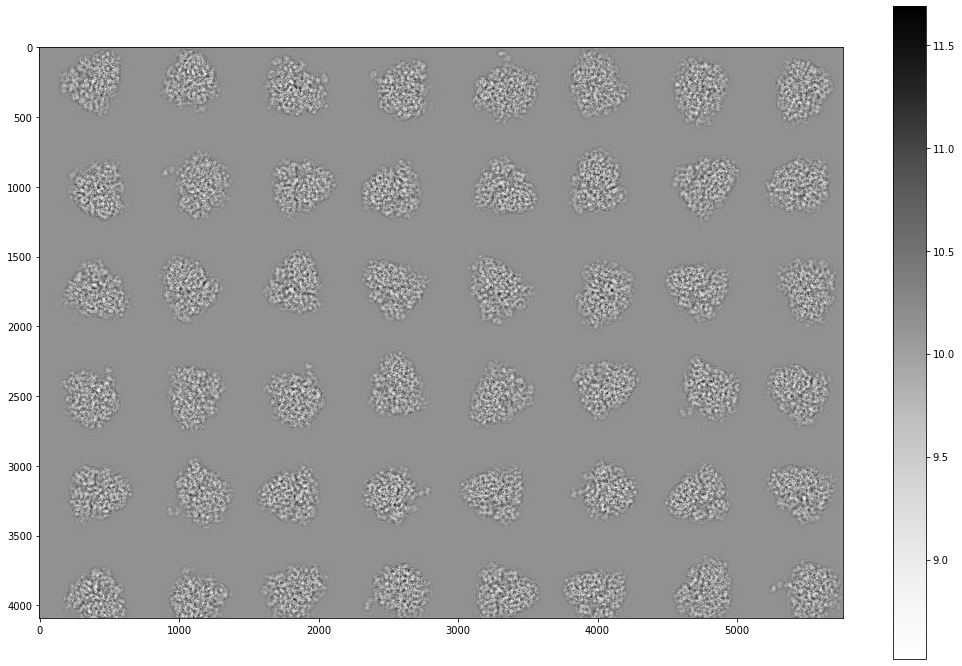

In [29]:
fig = plt.figure(figsize=(18,12))
plt.imshow(dd['data'],cmap='Greys')
plt.colorbar()